In [12]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from sklearn.linear_model import LogisticRegression
import pymc3 as pm
from google.colab import files
import seaborn as sns

## The Dataset

You can download the dataset from here: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database

In [3]:
uploaded = files.upload()

Saving diabetes.csv to diabetes.csv


In [4]:
## 1 point

## ToDo: read the csv file into a dataframe and show the first 5 rows

df = pd.read_csv("diabetes.csv")
print(df.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [5]:
## 3 points

## Assign the Outcome variable to y and the rest to X.
## USe LogisticRegression to fit the data and print out the intercept and the coefficients

from sklearn.model_selection import train_test_split
x = df.drop(['Outcome'],axis=1)
y = df.Outcome

from sklearn.preprocessing import StandardScaler
sc= StandardScaler()
x_scaled= sc.fit_transform(x)


x_train,x_test,y_train,y_test=train_test_split(x_scaled,y,test_size=0.3,random_state=0) 


logreg = LogisticRegression()
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_test)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(logreg, x_train, y_train, cv=10)

print(logreg.coef_, logreg.intercept_)

[[ 0.28826651  1.06937811 -0.21826045  0.09347351 -0.13893548  0.69506725
   0.25065813  0.28945097]] [-0.85075352]


In [7]:
## 2 points

## Explain what the code is doing:
## What are the prior probabilities of the intercept and coefficients?
## Which likelihood distribution has been used?
## What does pm.invlogit(linreg) mean?
## What is map_est?

## The random variables for the unobserved parameters for intercept and nine
## features are expressed using uninformative priors that assume normal
## distributions with a mean of 0 and a standard deviation of 100.

## The likelihood transforms rvs into probabilities p(y=1)
## according to logistic regression model.
## Outcome as Bernoulli rv with success probability
## given by sigmoid function conditioned on actual data

## pm.invlogit() is the Inverse-logit function \(logit^-1(x) = e^x/(1+e^x)\) 
## that transforms continuous values to the range (0, 1), which is necessary, 
## since probabilities must be between 0 and 1 and maps from the 
## linear predictor to the probabilities

## Maximum a posteriori probability (MAP) estimation leverages that the evidence 
## is a constant factor that scales the posterior to meet the requirements 
## for a probability distribution.
## The map_est give us the point MAP estimates for the parameters

diab_df = df

with pm.Model() as logreg_model:
  
    w0 = pm.Normal('w0', mu=0, sd=100)
    w1 = pm.Normal('w1', mu=0, sd=100)
    w2 = pm.Normal('w2', mu=0, sd=100)
    w3 = pm.Normal('w3', mu=0, sd=100)
    w4 = pm.Normal('w4', mu=0, sd=100)
    w5 = pm.Normal('w5', mu=0, sd=100)
    w6 = pm.Normal('w6', mu=0, sd=100)
    w7 = pm.Normal('w7', mu=0, sd=100)
    w8 = pm.Normal('w8', mu=0, sd=100)
   
    
    linreg = w0 * np.ones(diab_df.shape[0]) + w1 * diab_df.Pregnancies.values + w2 * diab_df.Glucose.values \
    + w3 * diab_df.BloodPressure.values + w4 * diab_df.SkinThickness.values + w5 * diab_df.Insulin.values + \
    w6 * diab_df.BMI.values + w7 * diab_df.DiabetesPedigreeFunction.values + w8 * diab_df.Age.values
    
    p_outcome = pm.invlogit(linreg)

    likelihood = pm.Bernoulli('likelihood', p_outcome, observed=diab_df.Outcome.values)

    
    map_est= pm.find_MAP()
    print(map_est)


{'w0': array(-8.40381811), 'w1': array(0.12319259), 'w2': array(0.03516101), 'w3': array(-0.01329351), 'w4': array(0.00062072), 'w5': array(-0.00119151), 'w6': array(0.08968112), 'w7': array(0.94539065), 'w8': array(0.0148632)}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Only 400 samples in chain.
Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [w8]
>Metropolis: [w7]
>Metropolis: [w6]
>Metropolis: [w5]
>Metropolis: [w4]
>Metropolis: [w3]
>Metropolis: [w2]
>Metropolis: [w1]
>Metropolis: [w0]


Sampling 2 chains for 1_000 tune and 400 draw iterations (2_000 + 800 draws total) took 22 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0ca2a471d0>,
      dtype=object)

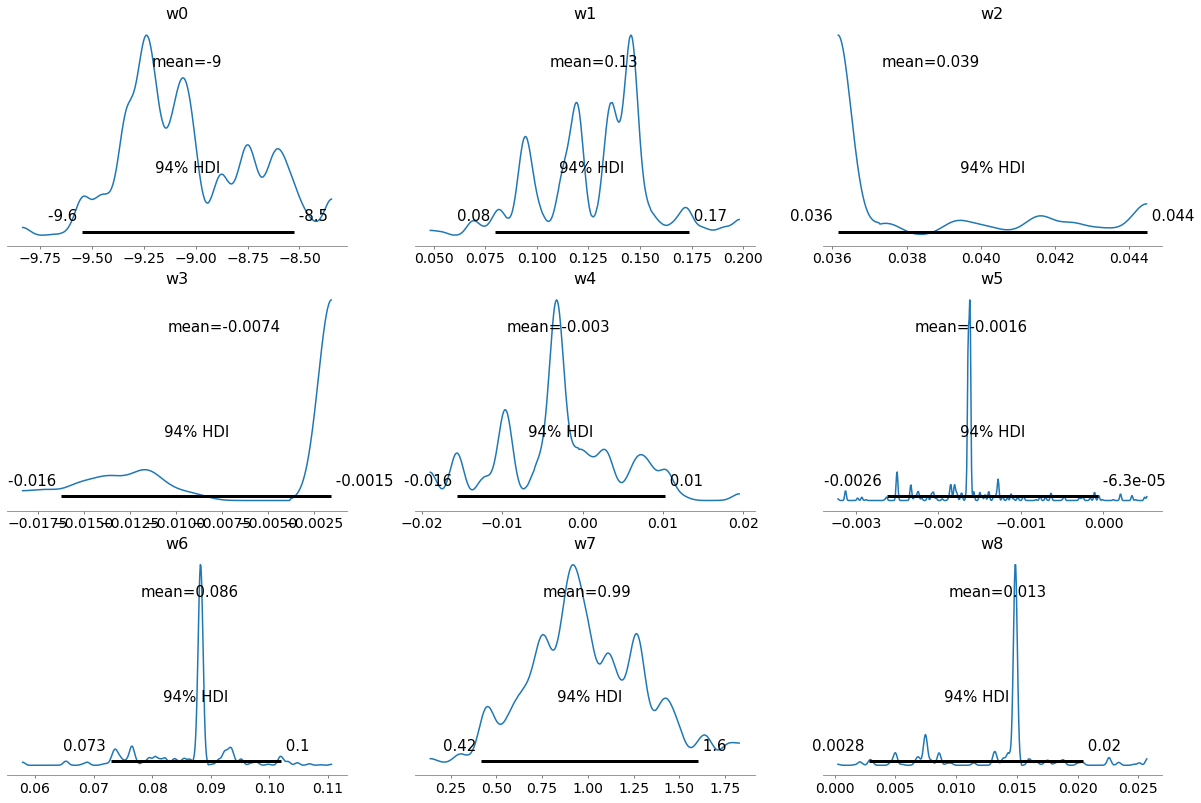

In [11]:
## 2 points

with logreg_model:
## ToDo: draw 400 samples using pm.Metropolis() and assign to the variable trace

  start = pm.find_MAP()
  step = pm.Metropolis()
  trace = pm.sample(400, step, start)


## Explain the output of the plot 
az.plot_posterior(trace)